# Detecting Blinks from the Pupil Signal

Many eye trackers (e.g., EyeLink) provide hardware-detected blink markers, but some
do not. Even when they do, you may want an independent detection method for validation
or for trackers that only provide a raw pupil signal.

pymovements includes a `blink` detection function that identifies blinks directly from
the pupil size time series. The algorithm adapts the differential detection approach of
[Hershman et al. (2018)](https://doi.org/10.3758/s13428-017-1008-1)
with a two-stage pipeline inspired by
[PupilPre](https://CRAN.R-project.org/package=PupilPre)
(Kyrolainen et al., 2019):

1. **Flagging** -- samples where pupil is NaN/zero or shows rapid changes (large absolute difference)
2. **Island absorption** -- short unflagged gaps between flagged regions are absorbed

Duration defaults (50--500 ms) follow
[Nystrom et al. (2024)](https://doi.org/10.3758/s13428-023-02333-9).

This tutorial demonstrates:
- Loading EyeLink data with `from_asc()`
- Inspecting the recording structure (participant, session, duration)
- Running algorithmic blink detection with `gaze.detect('blink')`
- Listing **all** detected blink instances with timing and duration
- Visualizing each blink in context
- Comparing with EyeLink hardware blink events
- Tuning detection parameters

In [35]:
import matplotlib.pyplot as plt
import numpy as np
import polars as pl

import pymovements as pm
from pymovements.gaze.io import from_asc

## 1. Load EyeLink Data

We use the `ToyDatasetEyeLink` dataset. The file name encodes the
**participant** and **session**: `subject_1_session_1.asc`.

We load with `events=True` so that hardware blink events (`blink_eyelink`)
are also available for comparison later.

In [36]:
# Download the dataset
dataset = pm.Dataset('ToyDatasetEyeLink', path='data/ToyDataset')
dataset.download()

# Load the first ASC file
raw_dir = dataset.paths.raw / 'pymovements-toy-dataset-eyelink-main'
asc_file = raw_dir / 'raw' / 'subject_1_session_1.asc'

gaze = from_asc(
    asc_file,
    patterns='eyelink',
    encoding='ascii',
    events=True,
)

print(f'File:    {asc_file.name}')
print(f'Subject: 1, Session: 1')
print(f'Samples: {gaze.samples.shape}')
print(f'Columns: {gaze.samples.columns}')
gaze.samples.head()

INFO:pymovements.dataset.dataset:
        You are downloading the pymovements Toy Dataset EyeLink. Please be aware that pymovements does not
        host or distribute any dataset resources and only provides a convenient interface to
        download the public dataset resources that were published by their respective authors.

        Please cite the referenced publication if you intend to use the dataset in your research.
        


Using already downloaded and verified file: data\ToyDataset\downloads\pymovements-toy-dataset-eyelink.zip
Extracting pymovements-toy-dataset-eyelink.zip to data\ToyDataset\raw


Extracting archive: 100%|██████████| 4/4 [00:00<00:00, 31.47file/s]


File:    subject_1_session_1.asc
Subject: 1, Session: 1
Samples: (128342, 3)
Columns: ['time', 'pupil', 'pixel']


time,pupil,pixel
i64,f64,list[f64]
2154556,778.0,"[138.1, 132.8]"
2154557,778.0,"[138.2, 132.7]"
2154558,778.0,"[138.2, 132.3]"
2154559,778.0,"[138.1, 131.9]"
2154560,777.0,"[137.9, 131.6]"


## 2. Understand the Recording

This ASC file contains a **single continuous recording** of one participant in one session.

The `time` column is in **milliseconds** (EyeLink native), but the values are large
absolute timestamps (ms since the tracker started). We convert to **seconds relative
to the recording start** for readable plots.

In [37]:
time_arr = gaze.samples['time'].to_numpy()
pupil_arr = gaze.samples['pupil'].to_numpy()

# Recording timing
t0 = time_arr[0]
duration_s = (time_arr[-1] - t0) / 1000

print(f'EyeLink time range: {t0:.0f} – {time_arr[-1]:.0f} ms')
print(f'Recording duration: {duration_s:.1f} s ({duration_s / 60:.1f} min)')
print(f'Sampling rate:      ~{len(time_arr) / duration_s:.0f} Hz')
print(f'Total samples:      {len(time_arr)}')

EyeLink time range: 2154556 – 2339291 ms
Recording duration: 184.7 s (3.1 min)
Sampling rate:      ~695 Hz
Total samples:      128342


## 3. Inspect the Raw Pupil Signal

The pupil signal typically drops to zero or NaN during blinks. Let's plot the
full recording using time relative to the start (in seconds) so the x-axis
is easy to interpret.

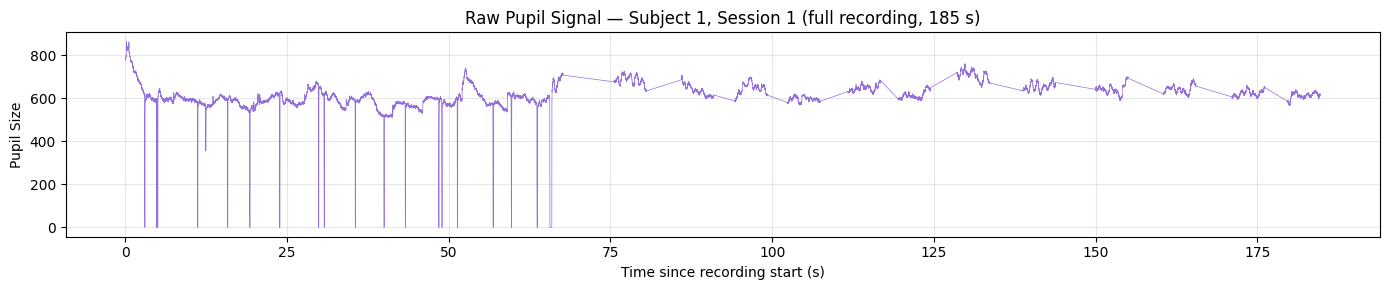

In [38]:
# Relative time in seconds for all plots
time_s = (time_arr - t0) / 1000

fig, ax = plt.subplots(figsize=(14, 3))
ax.plot(time_s, pupil_arr, color='mediumpurple', linewidth=0.5)
ax.set_xlabel('Time since recording start (s)')
ax.set_ylabel('Pupil Size')
ax.set_title(
    f'Raw Pupil Signal — Subject 1, Session 1 '
    f'(full recording, {duration_s:.0f} s)',
)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 4. Detect Blinks

We use `gaze.detect('blink')` which calls the blink detection algorithm. The function
automatically reads the `pupil` column from the gaze dataframe.

The detection algorithm adapts the differential approach of
[Hershman et al. (2018)](https://doi.org/10.3758/s13428-017-1008-1)
as implemented in [PupilPre](https://CRAN.R-project.org/package=PupilPre)
(Kyrolainen et al., 2019).

Default parameters:
- `delta=None` -- auto-estimated from the 95th percentile of absolute pupil differences
- `max_value_run=3` -- short gaps up to 3 samples are absorbed
- `nas_around_run=2` -- at least 2 flagged samples on each side to absorb a gap
- `minimum_duration=50` -- events shorter than 50 ms are discarded
- `maximum_duration=500` -- events longer than 500 ms are discarded

The 50--500 ms duration defaults follow
[Nystrom et al. (2024)](https://doi.org/10.3758/s13428-023-02333-9),
who established that typical blinks fall within this range. Events outside
this window are likely artifacts (too short) or extended eye closures (too long).

In [40]:
gaze.detect('blink')

detected_blinks = gaze.events.frame.filter(pl.col('name') == 'blink')
print(f'Detected {len(detected_blinks)} blink events')

Detected 66 blink events


### Complete list of all detected blinks

Each row is one blink event. We show onset/offset (original EyeLink ms),
duration, and time relative to recording start for easy reference.

In [33]:
blink_table = detected_blinks.select(
    pl.col('onset'),
    pl.col('offset'),
).with_columns(
    (pl.col('offset') - pl.col('onset')).alias('duration_ms'),
    ((pl.col('onset') - t0) / 1000).round(2).alias('onset_s'),
).with_row_index('blink_nr', offset=1)

# Show ALL rows — no truncation
with pl.Config(tbl_rows=-1):
    print(blink_table)

shape: (66, 5)
┌──────────┬─────────┬─────────┬─────────────┬─────────┐
│ blink_nr ┆ onset   ┆ offset  ┆ duration_ms ┆ onset_s │
│ ---      ┆ ---     ┆ ---     ┆ ---         ┆ ---     │
│ u32      ┆ i64     ┆ i64     ┆ i64         ┆ f64     │
╞══════════╪═════════╪═════════╪═════════════╪═════════╡
│ 1        ┆ 2157533 ┆ 2157598 ┆ 65          ┆ 2.98    │
│ 2        ┆ 2159344 ┆ 2159418 ┆ 74          ┆ 4.79    │
│ 3        ┆ 2159478 ┆ 2159589 ┆ 111         ┆ 4.92    │
│ 4        ┆ 2165695 ┆ 2165769 ┆ 74          ┆ 11.14   │
│ 5        ┆ 2166973 ┆ 2166981 ┆ 8           ┆ 12.42   │
│ 6        ┆ 2167010 ┆ 2167011 ┆ 1           ┆ 12.45   │
│ 7        ┆ 2170324 ┆ 2170411 ┆ 87          ┆ 15.77   │
│ 8        ┆ 2173745 ┆ 2173846 ┆ 101         ┆ 19.19   │
│ 9        ┆ 2178355 ┆ 2178469 ┆ 114         ┆ 23.8    │
│ 10       ┆ 2184392 ┆ 2184475 ┆ 83          ┆ 29.84   │
│ 11       ┆ 2185246 ┆ 2185334 ┆ 88          ┆ 30.69   │
│ 12       ┆ 2190068 ┆ 2190146 ┆ 78          ┆ 35.51   │
│ 13       ┆ 219

## 5. Blink-by-Blink Visualization

We plot each detected blink with ~500 ms of context on each side, so you
can see the pupil drop in detail. Time on the x-axis is relative to the
blink onset (in ms).

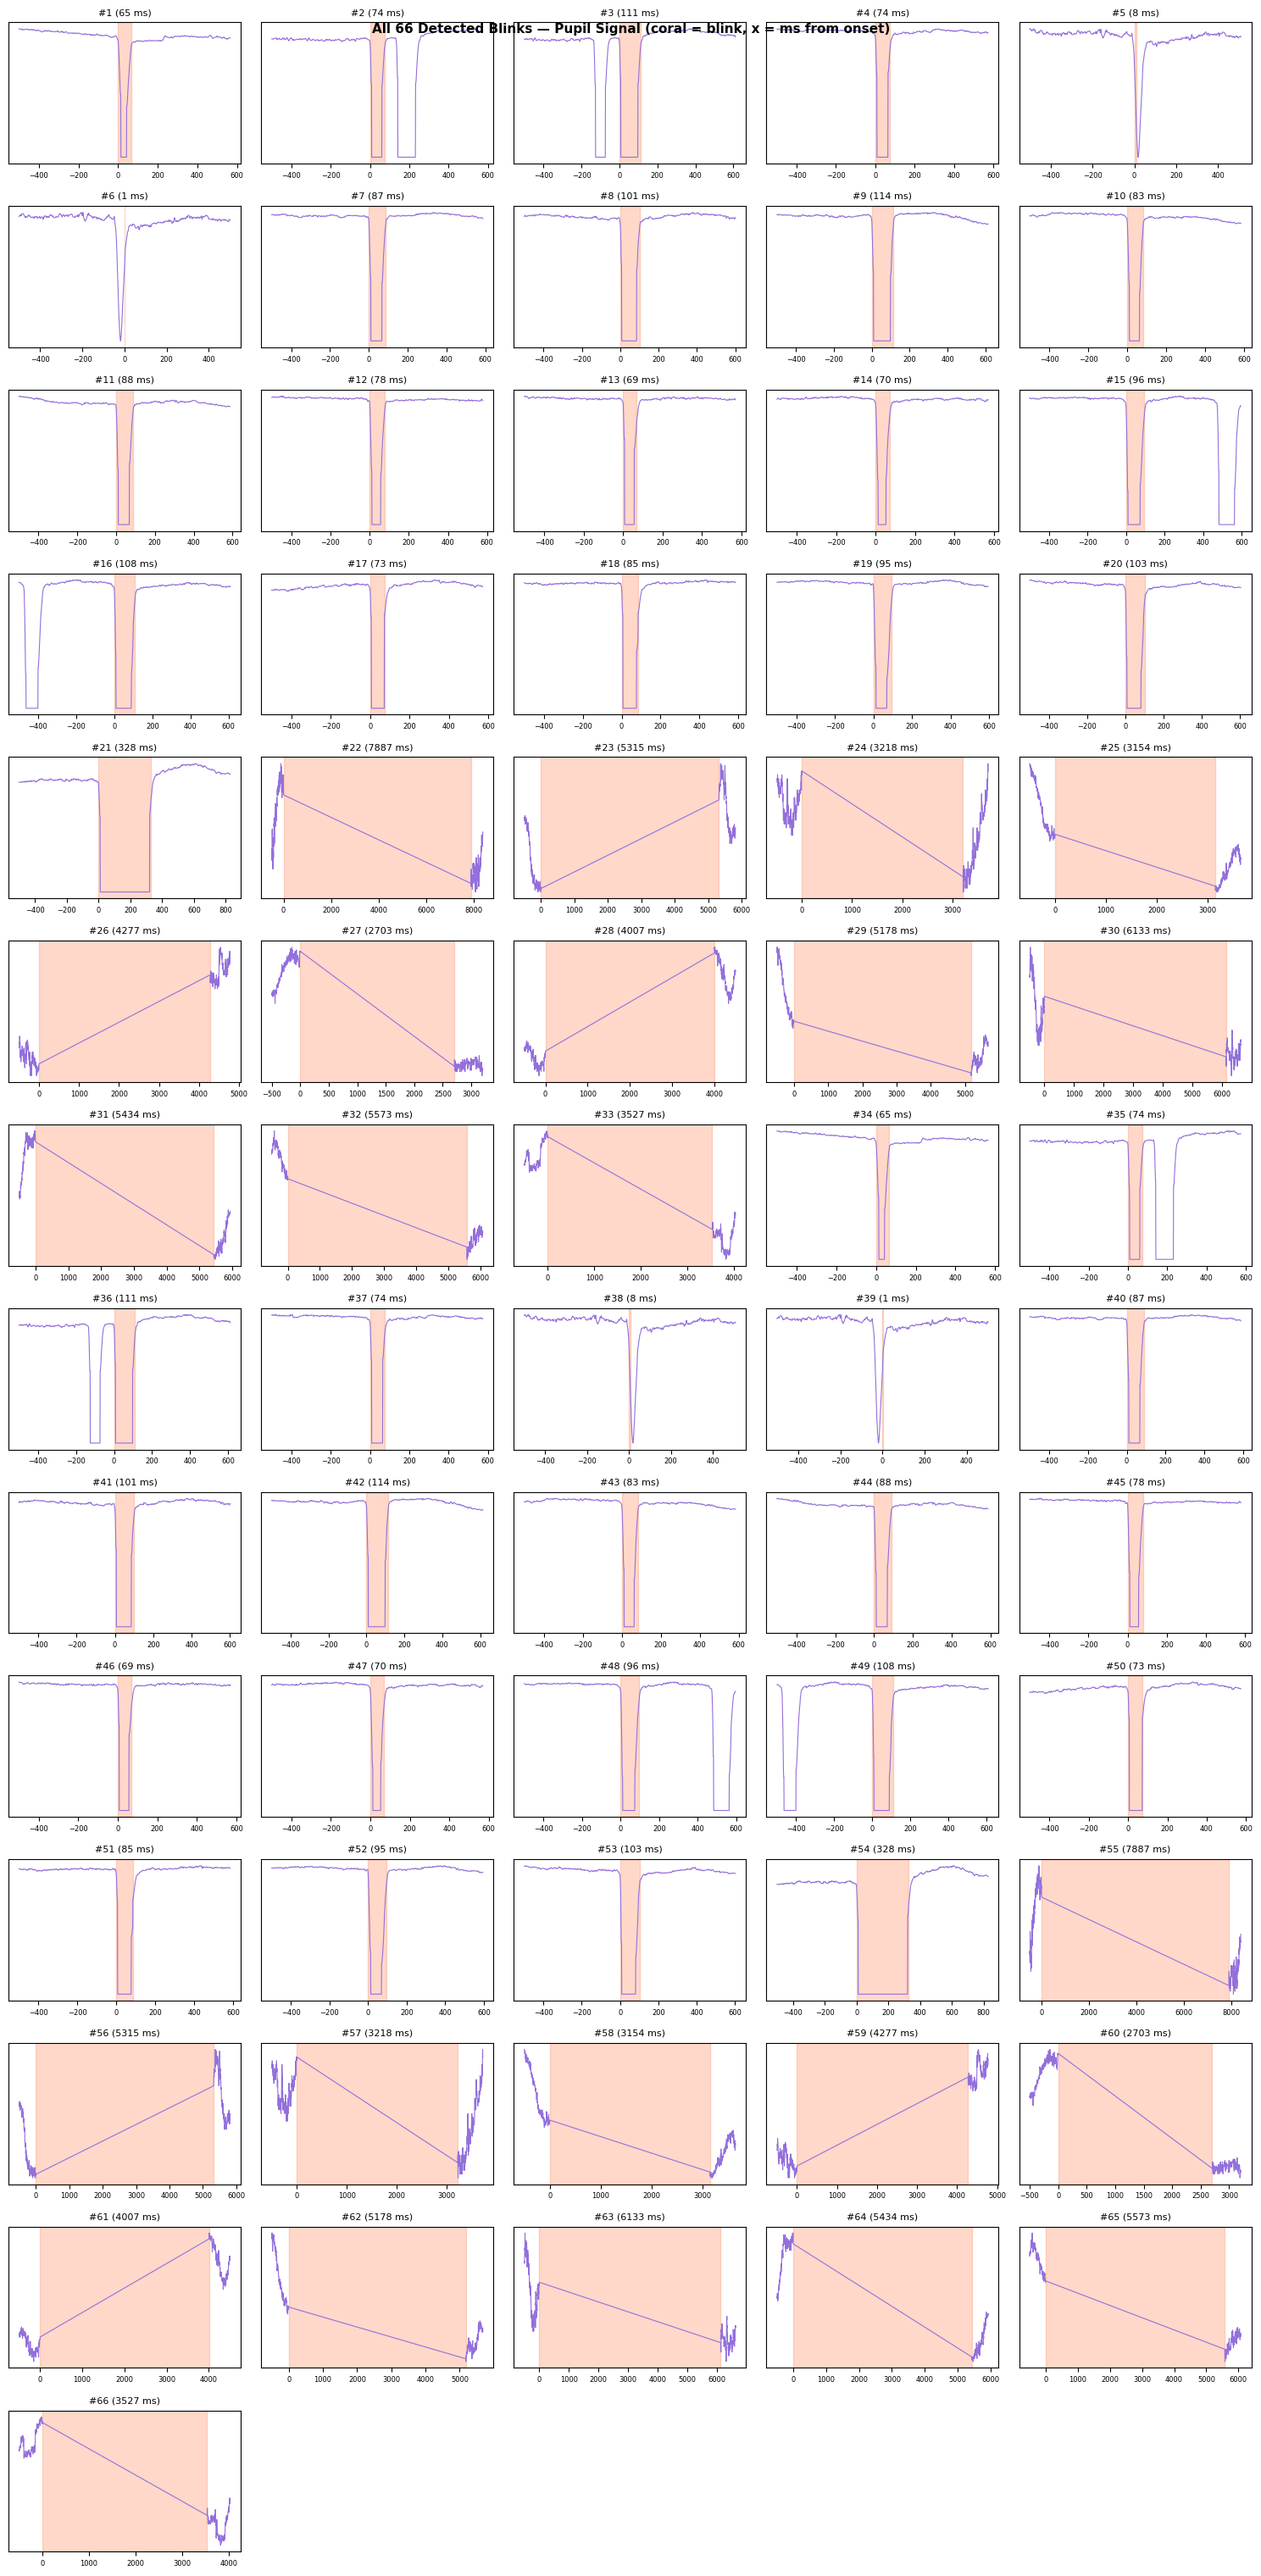

In [34]:
blink_onsets = detected_blinks['onset'].to_list()
blink_offsets = detected_blinks['offset'].to_list()

n_blinks = len(blink_onsets)
ncols = min(5, n_blinks)
nrows = max(1, int(np.ceil(n_blinks / ncols)))
context_ms = 500  # ms of context before/after blink

fig, axes = plt.subplots(
    nrows, ncols, figsize=(ncols * 3, nrows * 2.2), squeeze=False,
)

for idx in range(n_blinks):
    r, c = divmod(idx, ncols)
    ax = axes[r, c]

    onset = blink_onsets[idx]
    offset = blink_offsets[idx]
    dur = offset - onset
    win_start = onset - context_ms
    win_end = offset + context_ms

    mask = (time_arr >= win_start) & (time_arr <= win_end)
    # Time relative to blink onset (ms)
    t_rel = time_arr[mask] - onset

    ax.plot(t_rel, pupil_arr[mask], color='mediumpurple', linewidth=0.8)
    ax.axvspan(0, dur, alpha=0.3, color='coral')

    ax.set_title(f'#{idx + 1} ({dur} ms)', fontsize=8)
    ax.tick_params(labelsize=6)
    ax.set_yticks([])

# Hide unused subplots
for idx in range(n_blinks, nrows * ncols):
    r, c = divmod(idx, ncols)
    axes[r, c].set_visible(False)

fig.suptitle(
    f'All {n_blinks} Detected Blinks — Pupil Signal '
    f'(coral = blink, x = ms from onset)',
    fontsize=11, fontweight='bold',
)
plt.tight_layout()
plt.show()

## 6. Compare with EyeLink Hardware Blinks

Since we loaded with `events=True`, we also have `blink_eyelink` events from the
EyeLink hardware detector. Let's compare both.

In [ ]:
hw_blinks = gaze.events.frame.filter(pl.col('name') == 'blink_eyelink')
print(f'Hardware (EyeLink) blinks: {len(hw_blinks)}')
print(f'Algorithmic blinks:        {len(detected_blinks)}')

hw_onsets = hw_blinks['onset'].to_list()
hw_offsets = hw_blinks['offset'].to_list()

if len(hw_onsets) > 0:
    # Window around the first few hardware blinks
    focus_start = hw_onsets[0] - 500
    focus_end = hw_offsets[min(2, len(hw_offsets) - 1)] + 500
    mask = (time_arr >= focus_start) & (time_arr <= focus_end)
    focus_t_s = (time_arr[mask] - focus_start) / 1000

    fig, ax = plt.subplots(figsize=(14, 3.5))
    ax.plot(focus_t_s, pupil_arr[mask], color='mediumpurple', linewidth=0.8)

    for i, (on, off) in enumerate(zip(hw_onsets, hw_offsets)):
        if off >= focus_start and on <= focus_end:
            ax.axvspan(
                (on - focus_start) / 1000, (off - focus_start) / 1000,
                alpha=0.2, color='steelblue',
                label='EyeLink' if i == 0 else None,
            )

    for i, (on, off) in enumerate(zip(blink_onsets, blink_offsets)):
        if off >= focus_start and on <= focus_end:
            ax.axvspan(
                (on - focus_start) / 1000, (off - focus_start) / 1000,
                alpha=0.2, color='coral',
                label='Algorithmic' if i == 0 else None,
            )

    ax.legend(loc='upper right')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Pupil Size')
    ax.set_title('Hardware vs. Algorithmic Blink Detection')
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print('No hardware blink events found for comparison.')

## 7. Parameter Tuning

### What is `delta`?

`delta` is a threshold on **sample-to-sample pupil change**: if `|pupil[i+1] - pupil[i]| > delta`,
both samples get flagged as part of a blink.

**Why it matters:** The algorithm first flags samples where pupil is 0 or NaN (the *middle* of a
blink where the tracker lost the pupil entirely). But blinks also have *ramps* — the pupil signal
drops rapidly as the eyelid closes and recovers rapidly as it opens. `delta` catches these
transitional samples at the blink edges.

**When `delta=None` (default):** It is auto-estimated as `5 x 95th percentile` of all valid
`|diff(pupil)|`. This adapts to each recording — noisy data gets a higher threshold, clean data
gets a lower one.

**When to change it:**

| Situation | What you see | What to do |
|-----------|-------------|------------|
| False positives (non-blink artifacts flagged) | Pupil constriction or noise marked as blinks | **Increase** delta (e.g., 200-500) |
| Missed blinks (edges not captured) | Blink regions too narrow, missing the onset/offset ramps | **Decrease** delta (e.g., 20-50) |
| Very noisy recording | Auto-delta is too high due to overall noise | Set delta **explicitly** to a fixed value |
| Clean recording | Auto-delta works fine | Leave as `None` |

In [ ]:
from pymovements.events import blink as blink_fn

deltas = [None, 50.0, 200.0, 500.0]

# Focus window around first few blinks
if len(blink_onsets) > 0:
    focus_start = blink_onsets[0] - 500
    focus_end = blink_offsets[min(2, len(blink_offsets) - 1)] + 500
else:
    focus_start = t0
    focus_end = t0 + 5000

mask = (time_arr >= focus_start) & (time_arr <= focus_end)
focus_t_s = (time_arr[mask] - focus_start) / 1000

fig, axes = plt.subplots(len(deltas), 1, figsize=(14, 2.5 * len(deltas)), sharex=True)

for ax, d in zip(axes, deltas):
    events = blink_fn(
        pupil=pupil_arr,
        timesteps=time_arr.astype(int),
        delta=d,
    )

    ev_df = events.frame
    ax.plot(focus_t_s, pupil_arr[mask], color='mediumpurple', linewidth=0.8)

    if len(ev_df) > 0:
        for row in ev_df.to_dicts():
            on, off = row['onset'], row['offset']
            if off >= focus_start and on <= focus_end:
                ax.axvspan(
                    (on - focus_start) / 1000, (off - focus_start) / 1000,
                    alpha=0.3, color='coral',
                )

    label = f'delta={d}' if d is not None else 'delta=auto'
    ax.set_ylabel('Pupil', fontsize=9)
    ax.set_title(f'{label} — {len(ev_df)} events total', fontsize=10)
    ax.grid(True, alpha=0.3)

axes[-1].set_xlabel('Time (s)')
fig.suptitle('Effect of delta on Blink Detection', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

### What is `max_value_run`?

`max_value_run` controls **island absorption** — merging short unflagged gaps between flagged
regions. During a blink, the tracker sometimes recovers valid pupil readings for 1-3 samples
in the middle of an otherwise complete blink. Without absorption, this splits one real blink
into two or more events.

- `max_value_run=0` — disables absorption entirely (no merging)
- `max_value_run=3` (default) — gaps of up to 3 unflagged samples are absorbed if surrounded
  by at least `nas_around_run=2` flagged samples on each side
- `max_value_run=10` — aggressive merging, useful for very noisy data

**When to change it:** If you see single blinks split into multiple events, increase it.
If distinct close blinks are being incorrectly merged, decrease it.

In [ ]:
runs = [0, 1, 3, 10]

fig, axes = plt.subplots(len(runs), 1, figsize=(14, 2.5 * len(runs)), sharex=True)

for ax, mvr in zip(axes, runs):
    events = blink_fn(
        pupil=pupil_arr,
        timesteps=time_arr.astype(int),
        max_value_run=mvr,
    )

    ev_df = events.frame
    ax.plot(focus_t_s, pupil_arr[mask], color='mediumpurple', linewidth=0.8)

    if len(ev_df) > 0:
        for row in ev_df.to_dicts():
            on, off = row['onset'], row['offset']
            if off >= focus_start and on <= focus_end:
                ax.axvspan(
                    (on - focus_start) / 1000, (off - focus_start) / 1000,
                    alpha=0.3, color='coral',
                )

    ax.set_ylabel('Pupil', fontsize=9)
    ax.set_title(f'max_value_run={mvr} — {len(ev_df)} events total', fontsize=10)
    ax.grid(True, alpha=0.3)

axes[-1].set_xlabel('Time (s)')
fig.suptitle(
    'Effect of max_value_run on Blink Detection', fontsize=13, fontweight='bold',
)
plt.tight_layout()
plt.show()

### Duration filtering: `minimum_duration` and `maximum_duration`

Following [Nystrom et al. (2024)](https://doi.org/10.3758/s13428-023-02333-9),
typical blinks last **50--500 ms**. The defaults `minimum_duration=50` and
`maximum_duration=500` filter out events outside this range:

- Events **< 50 ms** are likely partial tracking losses or noise, not true blinks
- Events **> 500 ms** are likely extended eye closures or prolonged tracking loss

Set `maximum_duration=None` to disable the upper bound (e.g., if you want to
capture extended eye closures too).

In [ ]:
# Compare: default duration filter vs. no upper bound
events_default = blink_fn(
    pupil=pupil_arr,
    timesteps=time_arr.astype(int),
)
events_no_max = blink_fn(
    pupil=pupil_arr,
    timesteps=time_arr.astype(int),
    maximum_duration=None,
)
events_strict = blink_fn(
    pupil=pupil_arr,
    timesteps=time_arr.astype(int),
    minimum_duration=80,
    maximum_duration=300,
)

print(f'Default (50-500 ms):   {len(events_default.frame)} blinks')
print(f'No upper bound (50+ ms): {len(events_no_max.frame)} blinks')
print(f'Strict (80-300 ms):    {len(events_strict.frame)} blinks')

# Show the duration distribution
if len(events_no_max.frame) > 0:
    durations = events_no_max.frame['duration'].to_numpy()
    fig, ax = plt.subplots(figsize=(10, 3))
    ax.hist(durations, bins=30, color='mediumpurple', edgecolor='white', alpha=0.8)
    ax.axvline(50, color='coral', linestyle='--', linewidth=2, label='min=50 ms')
    ax.axvline(500, color='steelblue', linestyle='--', linewidth=2, label='max=500 ms')
    ax.set_xlabel('Blink Duration (ms)')
    ax.set_ylabel('Count')
    ax.set_title('Blink Duration Distribution (no upper bound)')
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

## Summary

- `blink()` detects blinks from the pupil signal without relying on eye-tracker markers
- The algorithm adapts [Hershman et al. (2018)](https://doi.org/10.3758/s13428-017-1008-1) as implemented in [PupilPre](https://CRAN.R-project.org/package=PupilPre) (Kyrolainen et al., 2019)
- Duration defaults follow [Nystrom et al. (2024)](https://doi.org/10.3758/s13428-023-02333-9): **50--500 ms**
- Key parameters: `delta` (sensitivity), `max_value_run` (gap merging), `minimum_duration` / `maximum_duration` (duration filtering)
- Use `gaze.detect('blink')` for seamless integration with the pymovements pipeline
- For cleaning blink artifacts from gaze data, see the [Blink Cleaning](blink-cleaning.ipynb) tutorial